# Imports

In [1]:
# Move to the root
import os
cwd = os.getcwd()
if os.path.basename(cwd) != "cv-in-farming":
    os.chdir("../")
print(os.getcwd())

/home/cengerkin/Desktop/cv-in-farming


## Standard Libraries

In [2]:
import random
import os
import time

import matplotlib
import numpy as np
from PIL import Image
import torch
from torch.utils.data import DataLoader
import torchvision.transforms.functional as F

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Custom Modules

In [3]:
from src.dataloader import *
from src.image_processing import *
from src.model import *
from src.solver import load_checkpoint, revert_input_transforms
from utils.helpers import *

# Definitions

In [4]:
def store_result(path, frame_id, image, pred):
#     edge_pixels = np.stack(np.nonzero(pred), axis=1)
#     np.save(os.path.join(path, f"{frame_id}_edge_pts.npy"), edge_pixels)
    overlaid = np.rint(overlay_mask(image, pred)* 255).astype(np.uint8)
    Image.fromarray(overlaid).save(os.path.join(path, f"{frame_id}_overlay.png"))
    
def load_result(path, frame_id):
    yx = np.load(os.path.join(path, f"{frame_id}_edge_pts.npy"))
    mask = np.zeros((480,640), dtype=np.uint8)
    mask[yx[:,0], yx[:,1]] = 255
    return mask

def evaluate():
    pass

# Load Frames

In [ ]:
normalize = True
input_format = 'darr'

dataset_args0 = {
    "data_path": "dataset/val/20210309_124809", # New capture
    "crop_down": False,
    "normalize": normalize,
    "input_format": input_format,
    "load_edge": False,
    "edge_width": 3,
    "load_time": False,
    "max_frames": 1000
}

dataset_args1 = {
    "data_path": "dataset/val/20210309_140259", # New capture
    "crop_down": False,
    "normalize": normalize,
    "input_format": input_format,
    "load_edge": False,
    "edge_width": 3,
    "load_time": False,
    "max_frames": 1000
}

folders = [FurrowDataset(dataset_args0), FurrowDataset(dataset_args1)]
for folder in folders:
    print(folder)

# Configure & Run

## Canny Edge Detector

* Input: RGB
* Grayscale + Gaussian Blur + Canny Edge Detector
* Output: 1-Channel Binary Mask

In [ ]:
canny_config = {
    "visualize": True,
    "ksize": (15,)*2, 
    "sigmaX": 30,
    "threshold1": 5000, 
    "threshold2": 11000, 
    "apertureSize": 7,
}

def canny_edge_detector(image, config):
#     image = convert_grayscale(image, config["visualize"])
    image = apply_gaussian_blur(image, config["visualize"], 
                                ksize=config["ksize"], 
                                sigmaX=config["sigmaX"])
#     _, threshold2 = apply_otsu_threshold(image, visualize=False)
    image = apply_canny(image, config["visualize"], 
                        threshold1=config["threshold1"],
                        threshold2=config["threshold2"],
                        apertureSize=config["apertureSize"])
    return image

### Single Frame

In [ ]:
# file_indices = list(range(0, 120))
# frame_idx = random.choice(file_indices)
# print("Frame choice:", frame_idx)
folder_idx = 0
frame_idx = 500
folder = folders[folder_idx]
item = folder.get_frame_files(frame_idx, 
                              load_darr=True,
                              load_rgb=True,
                              load_drgb=False,
                              load_edge=True,
                              load_time=False)

frame_id = item['frame_id']
print(f"Fetching frame: {frame_idx} <-> {frame_id}")
rgb_img = np.array(item['rgb_img'])

result = canny_edge_detector(rgb_img, canny_config)
overlaid = overlay_mask(rgb_img, result/255)
show_image(overlaid, cmap='gray', ticks=False)
# store_result("otsu_canny", frame_id, rgb_img, result)

### All Frames

## Otsu Thresholding

* Input: RGB
* Apply Grayscale + Gaussian Blur + Otsu Thresholding
* Output: 1-Channel Binary Mask

In [ ]:
otsu_config = {
    "visualize": True,
    "ksize": (3,3),
    "sigmaX": 10,
}
def otsu_thresholding(image, config):
    image = convert_grayscale(image, config["visualize"])
    image = apply_gaussian_blur(image, config["visualize"], 
                                ksize=config["ksize"], 
                                sigmaX=config["sigmaX"])
    image, _ = apply_otsu_threshold(image, config["visualize"])
    return image

### Single Frame

In [ ]:
# file_indices = list(range(0, 120))
# frame_idx = random.choice(file_indices)
# print("Frame choice:", frame_idx)
folder_idx = 0
frame_idx = 500
folder = folders[folder_idx]
item = folder.get_frame_files(frame_idx, 
                              load_darr=True,
                              load_rgb=True,
                              load_drgb=False,
                              load_edge=True,
                              load_time=False)

frame_id = item['frame_id']
print(f"Fetching frame: {frame_idx} <-> {frame_id}")
rgb_img = np.array(item['rgb_img'])

result = otsu_thresholding(rgb_img, otsu_config)
overlaid = overlay_mask(rgb_img, result/255)
show_image(overlaid, cmap='gray', ticks=False)
# store_result("otsu_canny", frame_id, rgb_img, result)

### All Frames

## Otsu + Canny

* Input: RGB
* Apply Grayscale + Gaussian Blur + Otsu Thresholding + Canny Edge Detector
* Output: 1-Channel Binary Mask

In [ ]:
otsu_canny_config = {
    "visualize": False,
    "ksize": (11,)*2,
    "sigmaX": 22,
    "apertureSize": 5,
}
def otsu_canny_edge_detector(image, config):
    image = convert_grayscale(image, config["visualize"])
    image = apply_gaussian_blur(image, config["visualize"], 
                                ksize=config["ksize"], 
                                sigmaX=config["sigmaX"])
    image, threshold2 = apply_otsu_threshold(image, config["visualize"])
    image = apply_canny(image, config["visualize"], 
                    threshold1=threshold2/2,
                    threshold2=threshold2,
                    apertureSize=config["apertureSize"])
    return image

### Single Frame

In [ ]:
# file_indices = list(range(0, 120))
# frame_idx = random.choice(file_indices)
# print("Frame choice:", frame_idx)
folder_idx = 1
frame_idx = 500
folder = folders[folder_idx]
item = folder.get_frame_files(frame_idx, 
                              load_darr=True,
                              load_rgb=True,
                              load_drgb=False,
                              load_edge=True,
                              load_time=False)

frame_id = item['frame_id']
print(f"Fetching frame: {frame_idx} <-> {frame_id}")
rgb_img = np.array(item['rgb_img'])

result = otsu_canny_edge_detector(rgb_img, otsu_canny_config)
overlaid = overlay_mask(rgb_img, result/255)
show_image(overlaid, cmap='gray', ticks=False)
# store_result("otsu_canny", frame_id, rgb_img, result)

### All Frames

In [ ]:
for folder in folders:
    folder_id = folder.folder_id
    for i in range(len(folder)):
        item = folder.get_frame_files(i,
                                      load_darr=False,
                                      load_rgb=True,
                                      load_drgb=False,
                                      load_edge=True,
                                      load_time=False)
        
        rgb_img = np.array(item['rgb_img'])
        frame_id = item['frame_id']
        
        result = otsu_canny_edge_detector(rgb_img, otsu_canny_config)
        store_result(f"benchmark/otsu_canny/{folder_id}", frame_id, rgb_img, result)

## Template Matching

* Input: Depth Array
* Apply Template Matching + RANSAC + Curve Fitting
* Output: Coordinates for Edge in the Mask

In [ ]:
parameters = {
    "template": {
        "size": 30,
        "position": 1,
    },
    "matching": {
        "start_depth": 0.92,  # Given in depth-scale
        "contour_width": 25, # Given in y-scale
        "y_step": 5,         # Given in y-scale
        "n_contours": 1000,
        "ransac_thresh": 30, #15
        "score_thresh": None,
        "roi": [None,None,250,None], # min_y:max_y, min_x:max_x
        "fit_type": "curve",
        "verbose": 0
    }
}

### Single Frame

In [ ]:
folder_idx = 1
frame_idx = 500
folder = folders[folder_idx]
item = folder.get_frame_files(frame_idx, 
                              load_darr=True,
                              load_rgb=True,
                              load_drgb=False,
                              load_edge=True,
                              load_time=False)

frame_id = item['frame_id']
print(f"Fetching frame: {frame_idx} <-> {frame_id}")
rgb_img = np.array(item['rgb_img'])
depth_arr = np.array(item['depth_arr'])

# Create a template to find corners
template = create_template(**parameters["template"])

# Fit a curve (2nd degree polynomial) to inlier detections
edge_pixels, inliers, outliers = apply_template_matching(depth_arr, template, **parameters["matching"])

overlaid = overlay_coord(rgb_img, edge_pixels, thickness=2)
show_image(overlaid, cmap='gray', ticks=False)

### All Frames

In [ ]:
path = "demo/template_matching"
normalize = True
input_format = 'darr'
dataset_args = {
    "data_path": "demo/frames", # New capture
    "crop_down": False,
    "normalize": normalize,
    "input_format": input_format,
    "load_edge": False,
    "edge_width": 3,
    "load_time": False,
}

folder = FurrowDataset(dataset_args)

for i in range(len(folder)):
    item = folder.get_frame_files(i, 
                                  load_darr=True,
                                  load_rgb=True,
                                  load_drgb=False,
                                  load_edge=False,
                                  load_time=False)

    frame_id = item['frame_id']
    rgb_img = np.array(item['rgb_img'])
    depth_arr = item['depth_arr']

    # Create a template to find corners
    template = create_template(**parameters["template"])

    # Fit a curve (2nd degree polynomial) to inlier detections
    edge_pixels, inliers, outliers = apply_template_matching(depth_arr, template, **parameters["matching"])

    edge_mask = coord_to_mask(rgb_img.shape, edge_pixels, thickness=2)
    store_result(path, frame_id, rgb_img, edge_mask / 255)

## HED (Original)

* Input: Depth Array or RGB
* Forward pass through network
* Output: 6-Channel Edge Score Mask

In [ ]:
model_args = {
    "pretrained": False,
    "freeze": False,
    "input_format": input_format
}
weight_map = {
 'stage1.0.weight':'moduleVggOne.0.weight',
 'stage1.0.bias': 'moduleVggOne.0.bias',
 'stage1.2.weight': 'moduleVggOne.2.weight',
 'stage1.2.bias': 'moduleVggOne.2.bias',
 'sideout1.0.weight': 'moduleScoreOne.weight',
 'sideout1.0.bias': 'moduleScoreOne.bias',
 'stage2.5.weight':  'moduleVggTwo.1.weight',
 'stage2.5.bias':  'moduleVggTwo.1.bias',
 'stage2.7.weight':  'moduleVggTwo.3.weight',
 'stage2.7.bias':  'moduleVggTwo.3.bias',
 'sideout2.0.weight':  'moduleScoreTwo.weight',
 'sideout2.0.bias':  'moduleScoreTwo.bias',
 'stage3.10.weight':  'moduleVggThr.1.weight',
 'stage3.10.bias':  'moduleVggThr.1.bias',
 'stage3.12.weight':  'moduleVggThr.3.weight',
 'stage3.12.bias':  'moduleVggThr.3.bias',
 'stage3.14.weight':  'moduleVggThr.5.weight',
 'stage3.14.bias':  'moduleVggThr.5.bias',
 'sideout3.0.weight':  'moduleScoreThr.weight',
 'sideout3.0.bias':  'moduleScoreThr.bias',
 'stage4.17.weight':  'moduleVggFou.1.weight',
 'stage4.17.bias':  'moduleVggFou.1.bias',
 'stage4.19.weight':  'moduleVggFou.3.weight',
 'stage4.19.bias':  'moduleVggFou.3.bias',
 'stage4.21.weight':  'moduleVggFou.5.weight',
 'stage4.21.bias':  'moduleVggFou.5.bias',
 'sideout4.0.weight':  'moduleScoreFou.weight',
 'sideout4.0.bias':  'moduleScoreFou.bias',
 'stage5.24.weight':  'moduleVggFiv.1.weight',
 'stage5.24.bias':  'moduleVggFiv.1.bias',
 'stage5.26.weight':  'moduleVggFiv.3.weight',
 'stage5.26.bias':  'moduleVggFiv.3.bias',
 'stage5.28.weight':  'moduleVggFiv.5.weight',
 'stage5.28.bias':  'moduleVggFiv.5.bias',
 'sideout5.0.weight':  'moduleScoreFiv.weight',
 'sideout5.0.bias':  'moduleScoreFiv.bias',
 'fuse.weight': 'moduleCombine.0.weight',
 'fuse.bias': 'moduleCombine.0.bias',
}

start_epoch = 0
ckpt_path = "checkpoint/network-bsds500.pytorch"
checkpoint = torch.load(ckpt_path)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = RidgeDetector(model_args)
model.to(device)
optim_choice = None
optim_args = {}

state = {}
for k1 in model.state_dict().keys():
    k2 = weight_map[k1]
    state[k1] = checkpoint[k2]
    
model.load_state_dict(state)

### Single Frame

In [ ]:
folder_idx = 1
frame_idx = 500
folder = folders[folder_idx]

item = folder.get_frame_files(frame_idx, 
                              load_darr=False,
                              load_rgb=True,
                              load_drgb=False,
                              load_edge=False,
                              load_time=False)
rgb_img = np.array(item['rgb_img'])

item = folder.__getitem__(frame_idx)
print(f"Fetching frame: {frame_idx} <-> {item['frame_id']}")
norm_img = item['input'].unsqueeze(0).cuda()

model.eval()
results = None
with torch.no_grad():
    results = model(norm_img)
    results = torch.sigmoid(results)

for result in results[0]:
    mask = result
    overlaid = overlay_mask(rgb_img, mask.cpu())
    show_image(overlaid, ticks=False)

### All Frames

## HED (Fine-tuned)

* Input: Depth Array or RGB or RGB + Depth Array
* Forward pass through network
* Output: 6-Channel Edge Score Mask

In [ ]:
ckpt_path = "checkpoint/exp2/darr/18_ckpt.pth"
# ckpt_path = "checkpoint/exp2/rgb/18_ckpt.pth"
# ckpt_path = "checkpoint/exp2/rgb-darr/18_ckpt.pth"

last_epoch, _, _, model, _, _, _, _ = load_checkpoint(ckpt_path)
start_epoch = last_epoch + 1

print(f"Model from epoch-{last_epoch} is loaded")

### Single Frame

In [ ]:
# normalize = True
# input_format = 'darr'

# dataset_args = {
#     "data_path": "dataset/val/20210309_140259", # New capture
#     "crop_down": False,
#     "normalize": normalize,
#     "input_format": input_format,
#     "load_edge": False,
#     "edge_width": 3,
#     "load_time": False,
# }

# folder = FurrowDataset(dataset_args)
# print(folder)

folder_idx = 1
frame_idx = 500
folder = folders[folder_idx]

item = folder.get_frame_files(frame_idx, 
                              load_darr=False,
                              load_rgb=True,
                              load_drgb=False,
                              load_edge=False,
                              load_time=False)
rgb_img = np.array(item['rgb_img'])

item = folder.__getitem__(frame_idx)
print(f"Fetching frame: {frame_idx} <-> {item['frame_id']}")
norm_img = item['input'].unsqueeze(0).cuda()

model.eval()
results = None
with torch.no_grad():
    results = model(norm_img)
    results = torch.sigmoid(results)

path = "resources/hed_on_interesting_cases/hed-no-mirror-aug"
for result in results[0]:
    mask = result
    overlaid = overlay_mask(rgb_img, mask.cpu())
    show_image(overlaid, ticks=False)

### All Frames

In [ ]:
from time import time
normalize = True
input_format = 'darr'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataset_args = {
    "data_path": "dataset/val/20210309_140259", # New capture
    "crop_down": False,
    "normalize": normalize,
    "input_format": input_format,
    "load_edge": False,
    "edge_width": 3,
    "load_time": False,
}

def detect_per_sample(model, sample, device):
    model.eval()

    with torch.no_grad():
        X = sample['input'].to(device)
        logits = model(X)
        preds = torch.sigmoid(logits)
        mask = preds[:,5:6,:,:][0,0]
        return mask.cpu().numpy()

dataset = FurrowDataset(dataset_args)
print(dataset)

batch_size = 1
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0)
print(f"Using device: {device}")
print(f"Batch count: {len(loader)}")

t1 = time()

path = "resources/hed_on_interesting_cases/hed-mirror-aug/detect"
model.to(device)
td = 0
for i, sample in enumerate(loader):
    item = dataset.get_frame_files(i,
                                   load_darr=False,
                                   load_rgb=True,
                                   load_drgb=False,
                                   load_edge=False,
                                   load_time=False)
    rgb_img = np.array(item['rgb_img'])
    td1 = time()
    mask = detect_per_sample(model, sample, device)
    td2 = time()
    td += (td2 - td1)
    store_result(path, item['frame_id'], rgb_img, mask)

t2 = time()
print("Total duration:", t2-t1)
print("Avg duration:", (t2-t1)/len(dataset))
print("Total detection duration:", td)
print("Avg detection duration:", td/len(dataset))

# Samples from November and March Captures

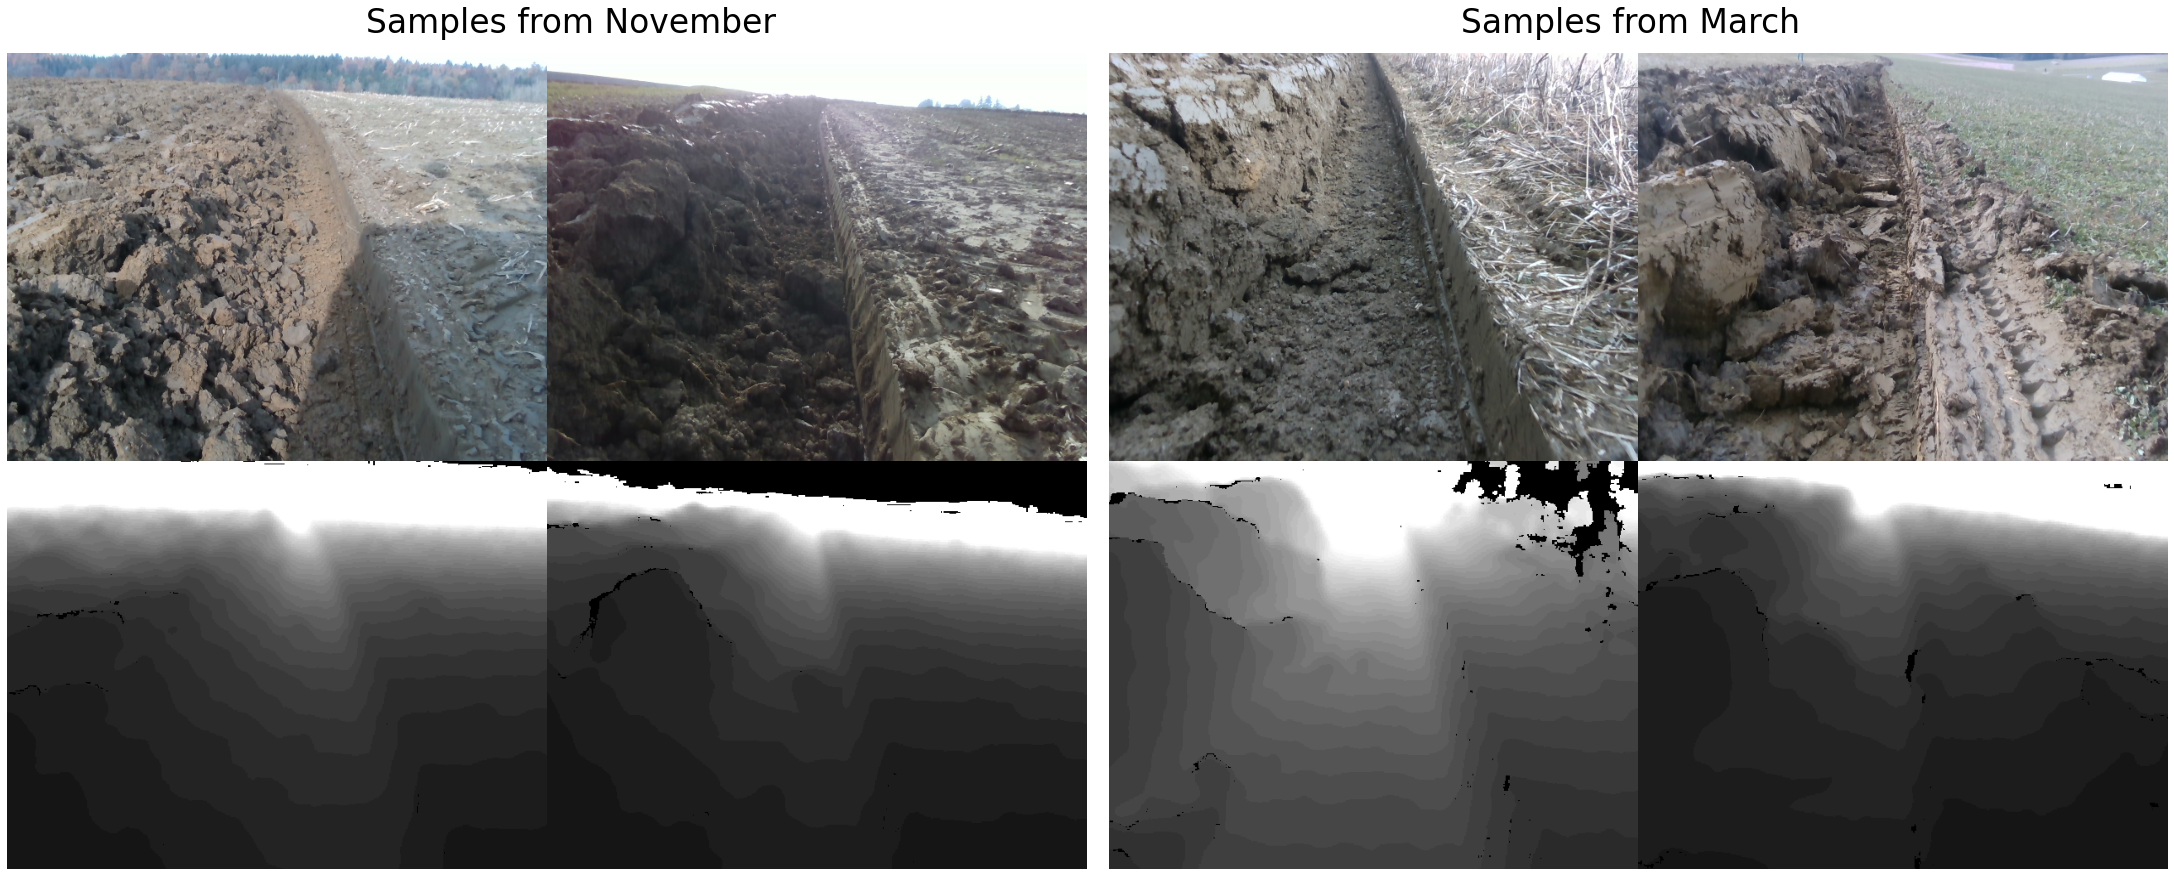

In [5]:
import matplotlib.gridspec as gridspec

def read_depth(path):
    depth_arr = np.load(path)
    depth_arr = np.rint(255 * (depth_arr / depth_arr.max()))
    depth_arr = np.clip(depth_arr * 7, a_min=0, a_max=255).astype(np.uint8)
    return depth_arr

fig = plt.figure(figsize=[15,15])
gs = gridspec.GridSpec(1, 4, wspace=0, hspace=0)

grid1 = np.array([
    [np.array(Image.open("/home/cengerkin/Desktop/Capture diff/November/3900_rgb.png")), np.array(Image.open("/home/cengerkin/Desktop/Capture diff/November/26600_rgb.png"))],
    [np.stack([read_depth("/home/cengerkin/Desktop/Capture diff/November/3900_depth.npy")]*3, axis=-1), np.stack([read_depth("/home/cengerkin/Desktop/Capture diff/November/26600_depth.npy")]*3, axis=-1)]
])

grid2 = np.array([
    [np.array(Image.open("/home/cengerkin/Desktop/Capture diff/March/3000_rgb.png")), np.array(Image.open("/home/cengerkin/Desktop/Capture diff/March/5000_rgb.png"))],
    [np.stack([read_depth("/home/cengerkin/Desktop/Capture diff/March/3000_depth.npy")]*3, axis=-1), np.stack([read_depth("/home/cengerkin/Desktop/Capture diff/March/5000_depth.npy")]*3, axis=-1)]
])

gs1 = gridspec.GridSpec(2, 2)
gs1.update(left=0, right=1, hspace=0, wspace=0)
for i in range(2):
    for j in range(2):
        ax = fig.add_subplot(gs1[i, j])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_frame_on(False)
        ax.imshow(grid1[i, j])
        ax.set_aspect("auto")
        if i == 0 and j == 0:
            ax.text(425, -25, 'Samples from November', size=33)
        
gs2 = gridspec.GridSpec(2, 2)
gs2.update(left=1.02, right=2, hspace=0, wspace=0)
for i in range(2):
    for j in range(2):
        ax = fig.add_subplot(gs2[i, j])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_frame_on(False)
        ax.imshow(grid2[i, j])
        ax.set_aspect("auto")
        if i == 0 and j == 0:
            ax.text(425, -25, 'Samples from March', size=33)

# Training Sample for HED

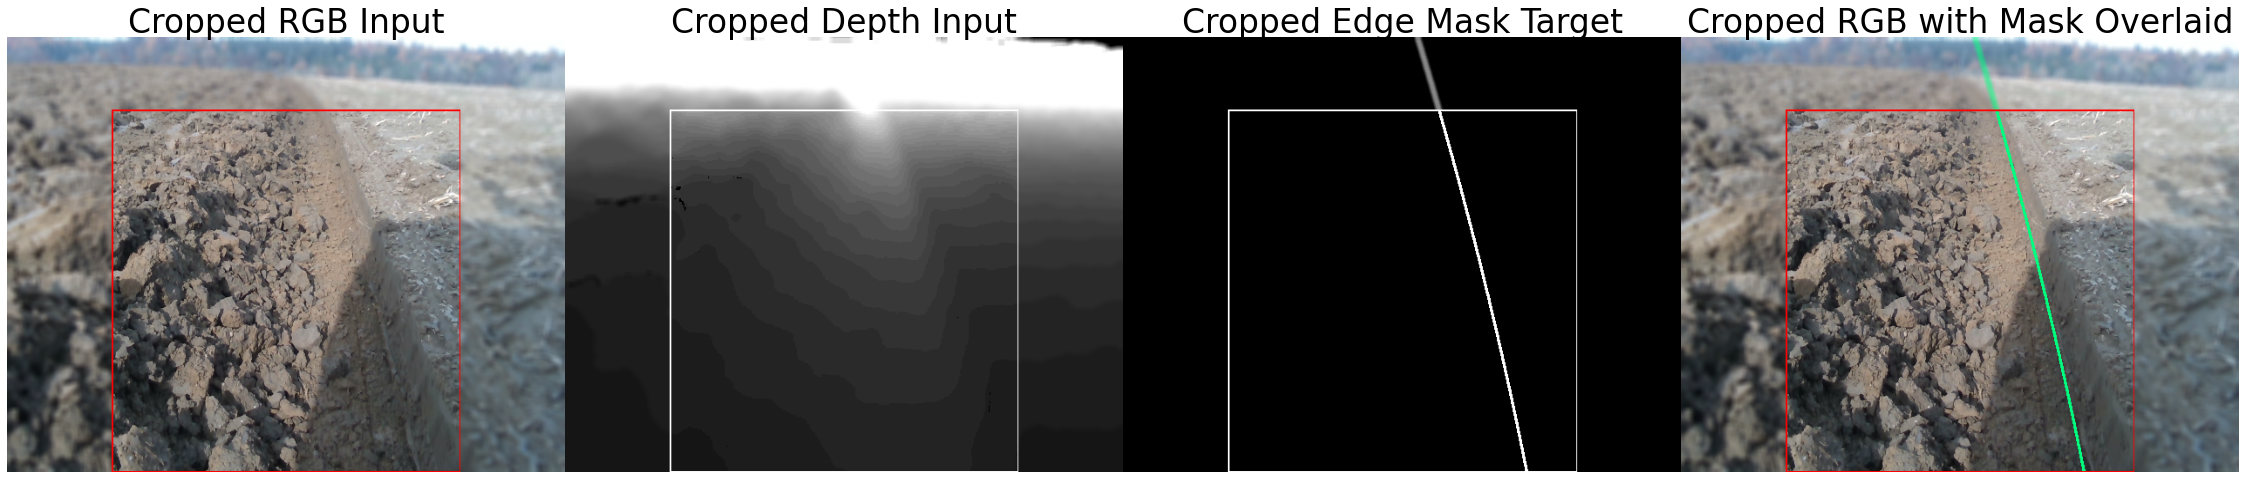

In [6]:
import matplotlib.gridspec as gridspec

normalize = True
input_format = 'rgb'

dataset_args = {
    "data_path": "dataset/train/20201112_125754", # New capture
    "crop_down": False,
    "normalize": normalize,
    "input_format": input_format,
    "load_edge": False,
    "edge_width": 3,
    "load_time": False,
}
folder = FurrowDataset(dataset_args)

frame_idx = 0
item = folder.get_frame_files(frame_idx, 
                              load_darr=True,
                              load_rgb=True,
                              load_drgb=False,
                              load_edge=True,
                              load_time=False)
rgb_img = np.array(item['rgb_img'])
depth_arr = item['depth_arr']
depth_arr = np.rint(255 * (depth_arr / depth_arr.max()))
depth_arr = np.clip(depth_arr * 7, a_min=0, a_max=255).astype(np.uint8)
edge_pixels = item['edge_pixels']

crop = cv2.rectangle(rgb_img.copy(), (120, 80), (520, 480), [255, 0, 0], thickness=2)
rgb_input = apply_gaussian_blur(rgb_img, False, ksize=(7,7), sigmaX=20)
rgb_input[80:480,120:520] = crop[80:480,120:520]
# show_image(rgb_input, ticks=False)

crop = cv2.rectangle(depth_arr.copy(), (120, 80), (520, 480), [255, 0, 0], thickness=2)
depth_input = apply_gaussian_blur(depth_arr, False, ksize=(7,7), sigmaX=20)
depth_input[80:480,120:520] = crop[80:480,120:520]
# show_image(depth_input, ticks=False, cmap="gray")

edge_mask = coord_to_mask((480,640), edge_pixels, thickness=2)
crop = cv2.rectangle(edge_mask.copy(), (120, 80), (520, 480), 255, thickness=2)
edge_img = apply_gaussian_blur(edge_mask, False, ksize=(7,7), sigmaX=20)
edge_img[80:480,120:520] = crop[80:480,120:520]
# show_image(edge_img, ticks=False, cmap="gray")

overlaid = overlay_coord(rgb_img, edge_pixels, thickness=2)
crop = cv2.rectangle(overlaid.copy(), (120, 80), (520, 480), [255, 0, 0], thickness=2)
overlay_rgb = apply_gaussian_blur(overlaid, False, ksize=(7,7), sigmaX=20)
overlay_rgb[80:480,120:520] = crop[80:480,120:520]
# show_image(overlay_rgb, ticks=False)

overlaid = overlay_coord(depth_arr, edge_pixels, thickness=2)
crop = cv2.rectangle(overlaid.copy(), (120, 80), (520, 480), 255, thickness=2)
overlay_darr = apply_gaussian_blur(overlaid, False, ksize=(7,7), sigmaX=20)
overlay_darr[80:480,120:520] = crop[80:480,120:520]
# show_image(overlay_darr, ticks=False, cmap="gray")

fig = plt.figure(figsize=[40,8])
gs = gridspec.GridSpec(1, 4, wspace=0, hspace=0)
imgs = np.array([
    rgb_input, np.stack([depth_input]*3, axis=-1), np.stack([edge_img]*3, axis=-1), overlay_rgb
])

labels = ["Cropped RGB Input", "Cropped Depth Input", "Cropped Edge Mask Target", "Cropped RGB with Mask Overlaid"]

for i in range(4):
    ax = fig.add_subplot(gs[0, i])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)
    ax.imshow(imgs[i])
    ax.set_aspect("auto")
    ax.xaxis.set_label_position('top') 
    ax.set_xlabel(labels[i], fontsize=33)

# Qualitative Results

## Template Matching vs HED on Extreme Cases

In [ ]:
frame_id = 9404
rgb_img = np.array(Image.open(f"dataset/val/extreme_cases/{frame_id}_rgb.png"))
depth_arr = np.load(f"dataset/val/extreme_cases/{frame_id}_depth.npy")
depth_arr = np.rint(255 * (depth_arr / MAX_DEPTH))
depth_arr = depth_arr.astype(np.uint8)
depth_arr = np.stack([depth_arr, depth_arr, depth_arr], axis=-1)
depth_arr = F.to_tensor(depth_arr)
depth_arr = F.normalize(depth_arr, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
depth_arr = depth_arr.unsqueeze(0).cuda()
model.eval()
results = None
with torch.no_grad():
    results = model(depth_arr)
    results = torch.sigmoid(results)

for result in results[0]:
    mask = result
    overlaid = overlay_mask(rgb_img, mask.cpu())
    show_image(overlaid, ticks=False)

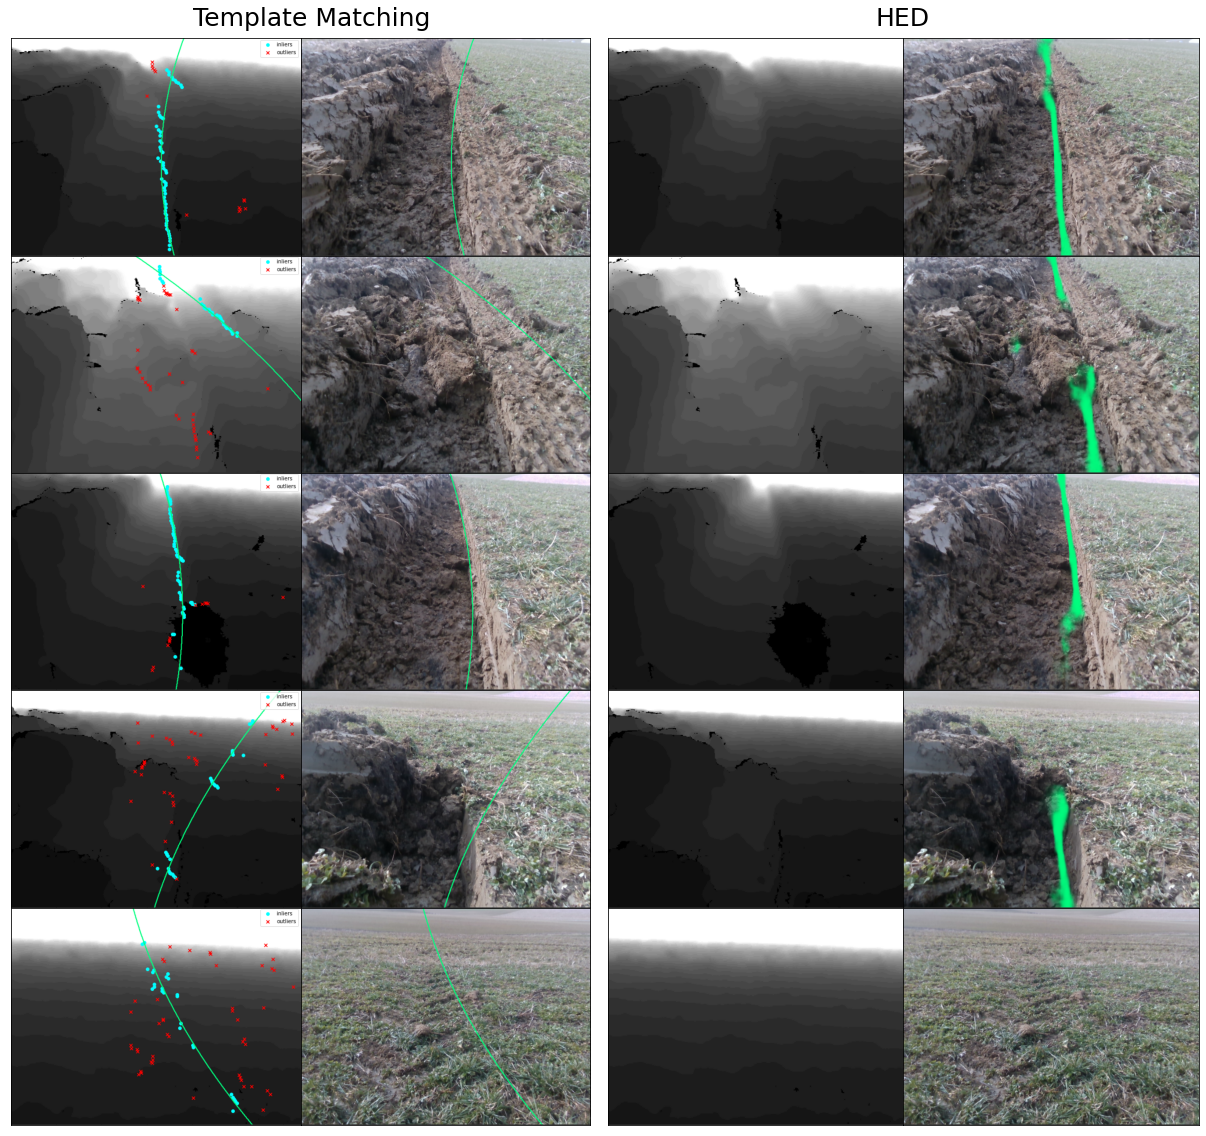

In [7]:
import matplotlib.gridspec as gridspec
tm = "resources/hed_vs_classic_extreme_cases/template_matching"
hed = "resources/hed_vs_classic_extreme_cases/hed-darr"

frame_ids = [5860, 5906, 8971, 9353, 9404]

col1 = []
col2 = []
col3 = []
col4 = []

for frame_id in frame_ids:
    col1.append(np.array(Image.open(f"{tm}/{frame_id}_edge_vis.png")))
    col2.append(np.array(Image.open(f"{tm}/{frame_id}_overlay.png")))
    col3.append(np.array(Image.open(f"{hed}/{frame_id}_depth.png")))
    col4.append(np.array(Image.open(f"{hed}/{frame_id}_overlay.png")))

grid1 = np.stack((col1, col2), axis=1)
grid2 = np.stack((col3, col4), axis=1)

nrows, ncols = grid1.shape[:2]

fig = plt.figure(figsize=[8.05,20])

gs1 = gridspec.GridSpec(5, 2)
gs1.update(left=0, right=1, hspace=0, wspace=0)
for i in range(nrows):
    for j in range(ncols):
        ax = fig.add_subplot(gs1[i, j])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(grid1[i,j])
        ax.set_aspect("auto")
        if i == 0 and j == 0:
            ax.text(350, -25, 'Template Matching', size=25)

gs2 = gridspec.GridSpec(5, 2)
gs2.update(left=1.03, right=2.05, hspace=0, wspace=0)
for i in range(nrows):
    for j in range(ncols):
        ax = fig.add_subplot(gs2[i, j])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(grid2[i,j])
        ax.set_aspect("auto")
        if i == 0 and j == 0:
            ax.text(505, -25, 'HED', size=25)

plt.show()

## Compare Best of Each Method on a Frame

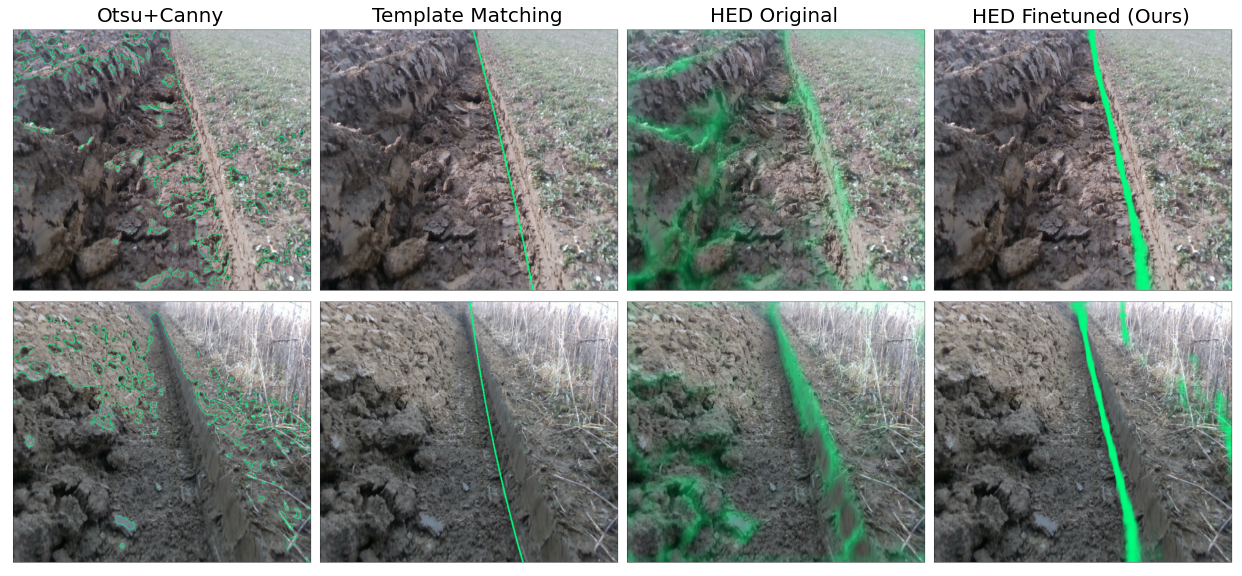

In [8]:
import matplotlib.gridspec as gridspec
path = "resources/compare_best_on_single_image"
fig = plt.figure(figsize=[22,10])

# fig.suptitle("Comparison of Different Models with Best Achieved Settings", fontsize=30, y=0.97)

labels = ["Otsu+Canny", "Template Matching", "HED Original", "HED Finetuned (Ours)"]

gs = gridspec.GridSpec(2, 4, wspace=0, hspace=0)
imgs = np.array([
    [np.array(Image.open(f"{path}/otsu+canny1.png")), np.array(Image.open(f"{path}/template_matching1.png")), np.array(Image.open(f"{path}/hed_original1.png")), np.array(Image.open(f"{path}/hed-darr1.png"))],
    [np.array(Image.open(f"{path}/otsu+canny2.png")), np.array(Image.open(f"{path}/template_matching2.png")), np.array(Image.open(f"{path}/hed_original2.png")), np.array(Image.open(f"{path}/hed-darr2.png"))],
])

for i in range(2):
    for j in range(4):
        ax = fig.add_subplot(gs[i, j])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_frame_on(False)
        ax.imshow(imgs[i, j])
        ax.set_aspect("auto")
        if i == 0:
            ax.xaxis.set_label_position('top') 
            ax.set_xlabel(labels[j], fontsize=20)

plt.show()

## HED Side Outputs

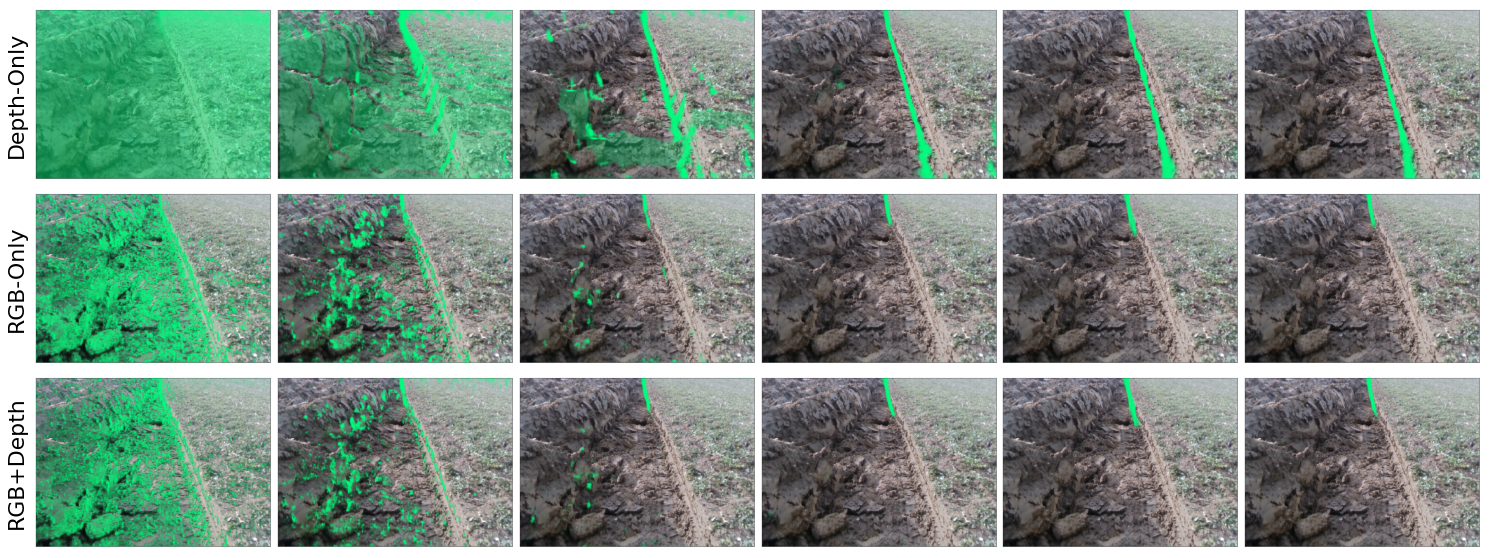

In [9]:
darr = "resources/hed_finetuned_darr_scales"
rgb = "resources/hed_finetuned_rgb_scales"
rgb_darr = "resources/hed_finetuned_rgb-darr_scales"

grid = [[], [], []]
labels = ["Depth-Only", "RGB-Only", "RGB+Depth"]

for i in range(1,7):
    grid[0].append(np.array(Image.open(f"{darr}/scale{i}.png")))
    grid[1].append(np.array(Image.open(f"{rgb}/scale{i}.png")))
    grid[2].append(np.array(Image.open(f"{rgb_darr}/scale{i}.png")))

fig = plt.figure(figsize=[26, 10], frameon=False)
# fig.suptitle("HED Side Outputs with Different Inputs", fontsize=30, y=0.94)
gs = gridspec.GridSpec(3, 6, wspace=0, hspace=0.05)

for i in range(3):
    for j in range(6):
        ax = fig.add_subplot(gs[i, j])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_frame_on(False)
        ax.imshow(grid[i][j])
        ax.set_aspect("auto")
        if j == 0:
            ax.set_ylabel(labels[i], fontsize=22)
plt.show()

## Effect of Data Augmentation on HED

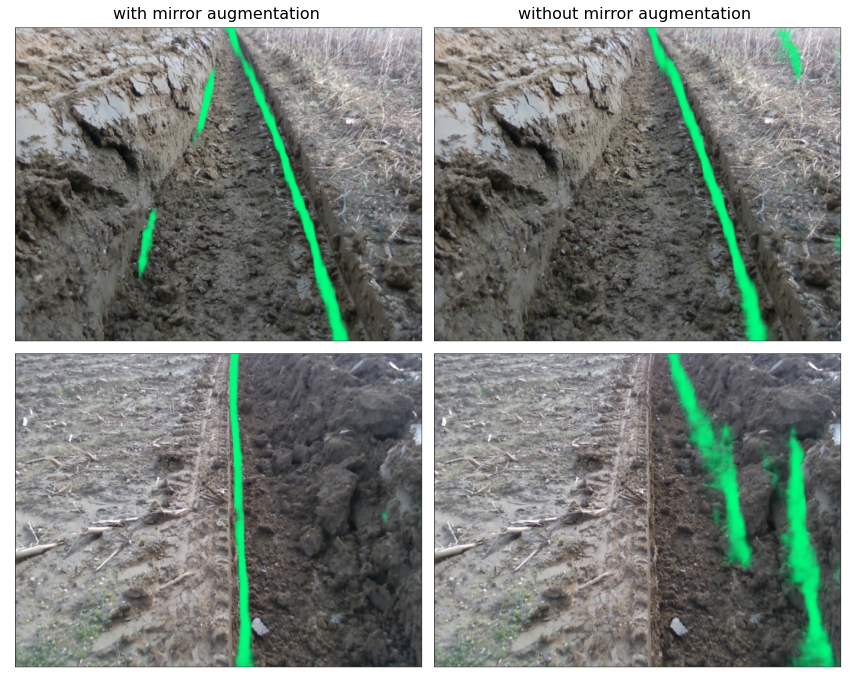

In [10]:
import matplotlib.gridspec as gridspec
path1 = "resources/hed_on_interesting_cases/hed-mirror-aug"
path2 = "resources/hed_on_interesting_cases/hed-no-mirror-aug"
fig = plt.figure(figsize=[15,12], frameon=False)
# fig.suptitle("HED: Effect of Mirror Augmentation on Predictions", fontsize=30, y=0.91)

labels = ["with mirror augmentation", "without mirror augmentation"]

gs = gridspec.GridSpec(2, 2, wspace=0, hspace=0)
imgs = np.array([
    [np.array(Image.open(f"{path1}/front-1.png")), np.array(Image.open(f"{path2}/front-1.png"))],
    [np.array(Image.open(f"{path1}/back-2.png")), np.array(Image.open(f"{path2}/back-2.png"))]
])


for i in range(2):
    for j in range(2):
        ax = fig.add_subplot(gs[i, j])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_frame_on(False)
        ax.imshow(imgs[i, j])
        ax.set_aspect("auto")
        if i == 0:
            ax.xaxis.set_label_position('top')
            ax.set_xlabel(labels[j], fontsize=16)

plt.show()

## Generate Video

### Template Matching

In [ ]:
from matplotlib.animation import FFMpegWriter

plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'

folder = "demo/template_matching"

files = os.listdir(folder)

rgb_im_files = []
edge_px_files = []

# Filter files wrt their extension
for file in files:
    if file.endswith("rgb.png"):
        rgb_im_files.append(file)
    if file.endswith("edge_pts.npy"):
        edge_px_files.append(file)

rgb_im_files = sorted(rgb_im_files, key=lambda f: int(f.split("_")[0]))
edge_px_files = sorted(edge_px_files, key=lambda f: int(f.split("_")[0]))

fig = plt.figure()
cut = range(1164, 2965)

metadata = dict(title='Template Matching Detector')
writer = FFMpegWriter(fps=30, metadata=metadata)

fig = plt.figure()
plt.xticks([])
plt.yticks([])
imgh = plt.imshow(np.zeros((480, 640), dtype=np.uint8))

with writer.saving(fig, "demo/Template Matching.mp4", 100):
    for i in cut:
        rgb_im_file = rgb_im_files[i]
        edge_px_file = edge_px_files[i]
        
        frame_idx = rgb_im_file.split("_")[0]

        rgb_im_path = os.path.join(folder, rgb_im_file)
        rgb_img = cv2.imread(rgb_im_path, cv2.IMREAD_COLOR)
        
        edge_px_path = os.path.join(folder, f"{frame_idx}_edge_pts.npy")
        edge_pixels = np.load(edge_px_path)
        overlaid = overlay_coord(rgb_img, edge_pixels, thickness=2)
        
        imgh.set_data(overlaid)
        
        writer.grab_frame()

### HED

In [ ]:
from matplotlib.animation import FFMpegWriter

plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'

folder = "demo/hed"

files = os.listdir(folder)

rgb_im_files = []

# Filter files wrt their extension
for file in files:
    if file.endswith(".png"):
        rgb_im_files.append(file)

rgb_im_files = sorted(rgb_im_files, key=lambda f: int(f.split("_")[0]))

fig = plt.figure()
cut = rgb_im_files#[1164:2964]

metadata = dict(title='HED Detector')
writer = FFMpegWriter(fps=30, metadata=metadata)

fig = plt.figure()
plt.xticks([])
plt.yticks([])
imgh = plt.imshow(np.zeros((480, 640), dtype=np.uint8))

with writer.saving(fig, "demo/HED.mp4", 100):
    for rgb_im_file in cut:
        frame_idx = rgb_im_file.split("_")[0]

        rgb_im_path = os.path.join(folder, rgb_im_file)
        rgb_img = cv2.imread(rgb_im_path, cv2.IMREAD_COLOR)
        
        imgh.set_data(rgb_img)
        
        writer.grab_frame()